In [21]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import os
import cv2
import IPython
import IPython.display as ipd 
import librosa 
import librosa.display
import numpy as np
import seaborn as sns
import shutil

from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



In [22]:
train = pd.read_csv("../input/freesound-audio-tagging/train.csv")
test = pd.read_csv("../input/freesound-audio-tagging/sample_submission.csv")
train.head()

fname         label  manually_verified
0  00044347.wav        Hi-hat                  0
1  001ca53d.wav     Saxophone                  1
2  002d256b.wav       Trumpet                  0
3  0033e230.wav  Glockenspiel                  1
4  00353774.wav         Cello                  1

In [23]:
print("Number of training examples=", train.shape[0], "  Number of classes=", len(train.label.unique())) #количество звуков и кол-во классов

Number of training examples= 9473   Number of classes= 41


In [24]:
print(train.label.unique()) #название классов

['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']


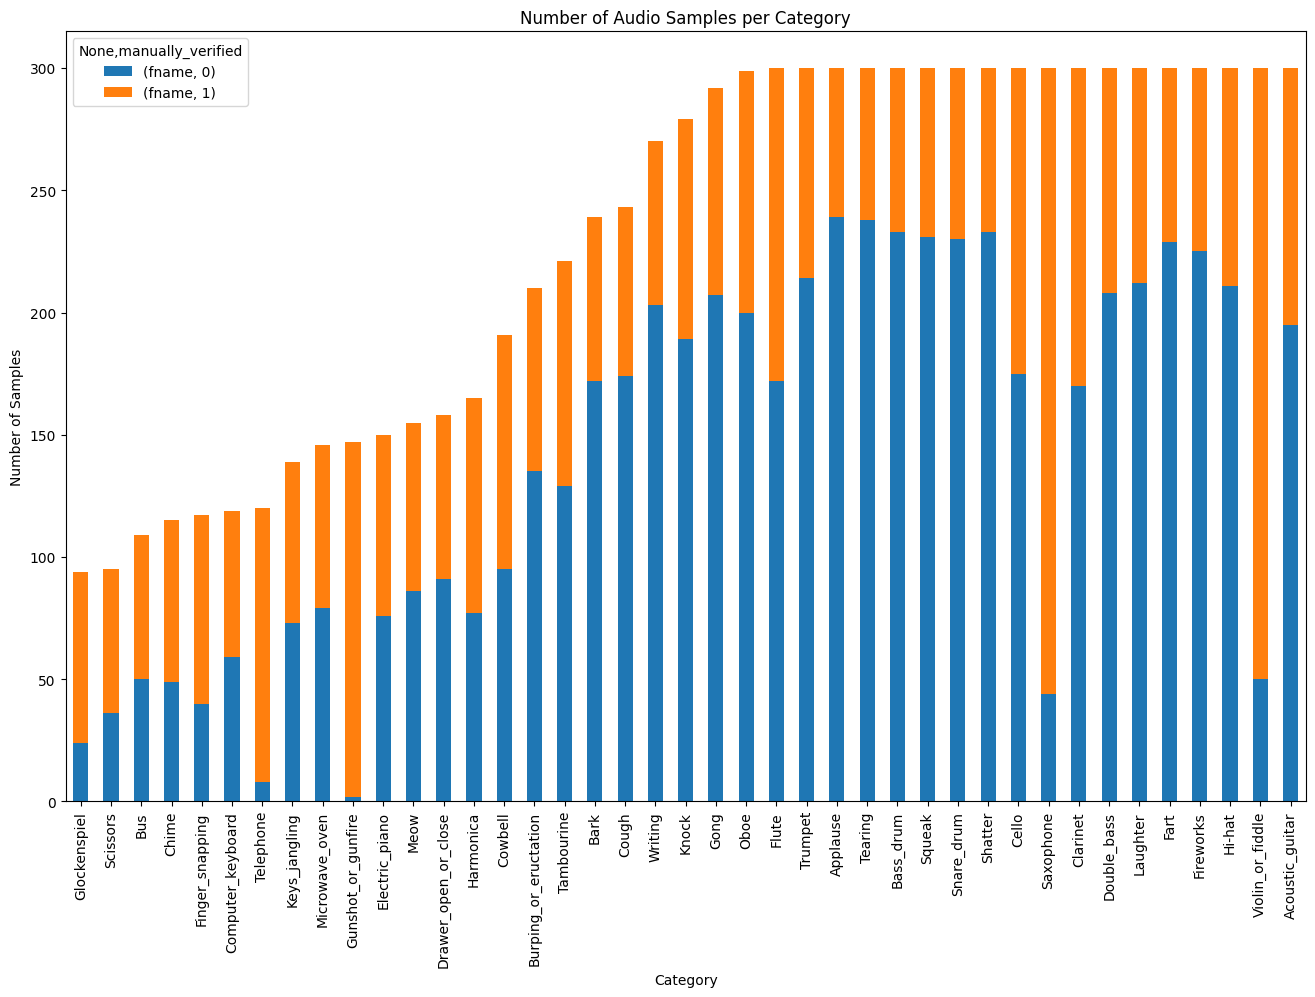

In [25]:
#распределение по категориям
category_group = train.groupby(['label', 'manually_verified']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

In [26]:
#минимальное и максимально колво звуков в категории
print('Minimum samples per category = ', min(train.label.value_counts()))
print('Maximum samples per category = ', max(train.label.value_counts()))

Minimum samples per category =  94
Maximum samples per category =  300


In [55]:
#
import IPython.display as ipd  # To play sound in the notebook
fname = '../input/freesound-audio-tagging/audio_train/' + '00044347.wav'   # Hi-hat
ipd.Audio(fname)

In [36]:
# Using wave library
import wave
wav = wave.open(fname)
print("Sampling (frame) rate = ", wav.getframerate()) # кол-во образцов с сек
print("Total samples (frames) = ", wav.getnframes()) #общее кол-во образцов в аудиофайле
print("Duration = ", wav.getnframes()/wav.getframerate()) #продолжительность 

Sampling (frame) rate =  44100
Total samples (frames) =  617400
Duration =  14.0


In [38]:
# Using scipy
from scipy.io import wavfile
rate, data = wavfile.read(fname)
print("Sampling (frame) rate = ", rate) #частотa дискретизации аудиофайла 
print("Total samples (frames) = ", data.shape)# количество кадров и количество каналов в аудиофайле.
print(data)# 

Sampling (frame) rate =  44100
Total samples (frames) =  (617400,)
[ 0 26 -5 ...  1  0  0]


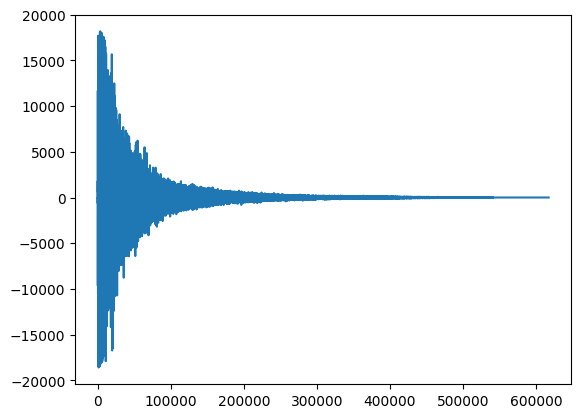

In [39]:
#диаграма аудиокадров
plt.plot(data, '-', );

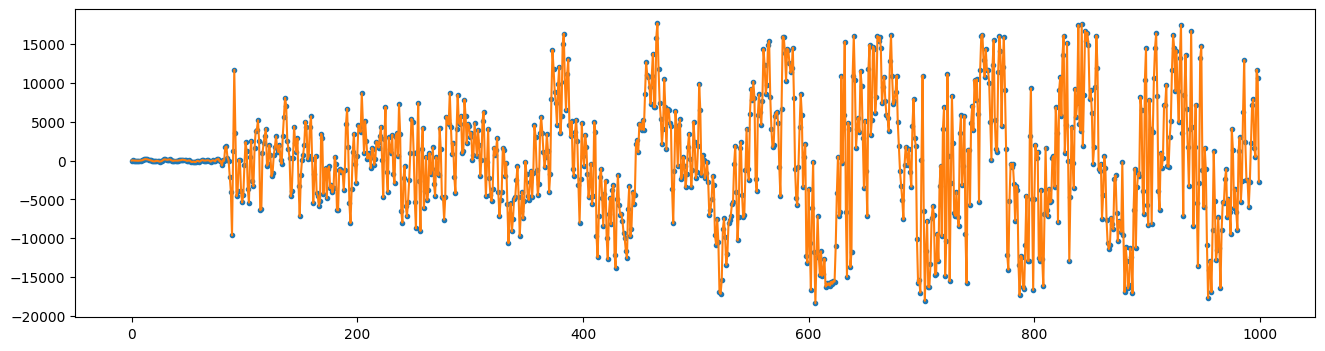

In [41]:
#диаграма первых 1000 аудиоканалов 
plt.figure(figsize=(16, 4))
plt.plot(data[:1000], '.'); plt.plot(data[:1000], '-');

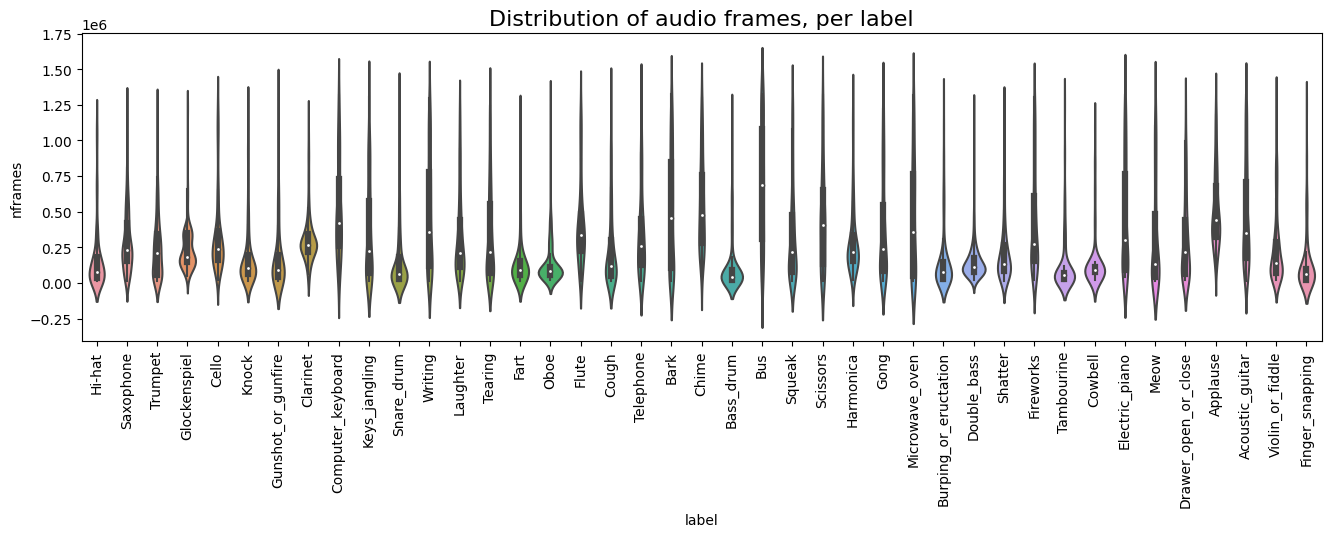

In [42]:
#Анализ длины аудиофайлов. Диаграмма показывает, как распределяются длины аудиозаписей в разных классах.
train['nframes'] = train['fname'].apply(lambda f: wave.open('../input/freesound-audio-tagging/audio_train/' + f).getnframes())
test['nframes'] = test['fname'].apply(lambda f: wave.open('../input/freesound-audio-tagging/audio_test/' + f).getnframes())

_, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(ax=ax, x="label", y="nframes", data=train)
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()
#Распределение длины звука по меткам неравномерно и имеет высокую дисперсию.

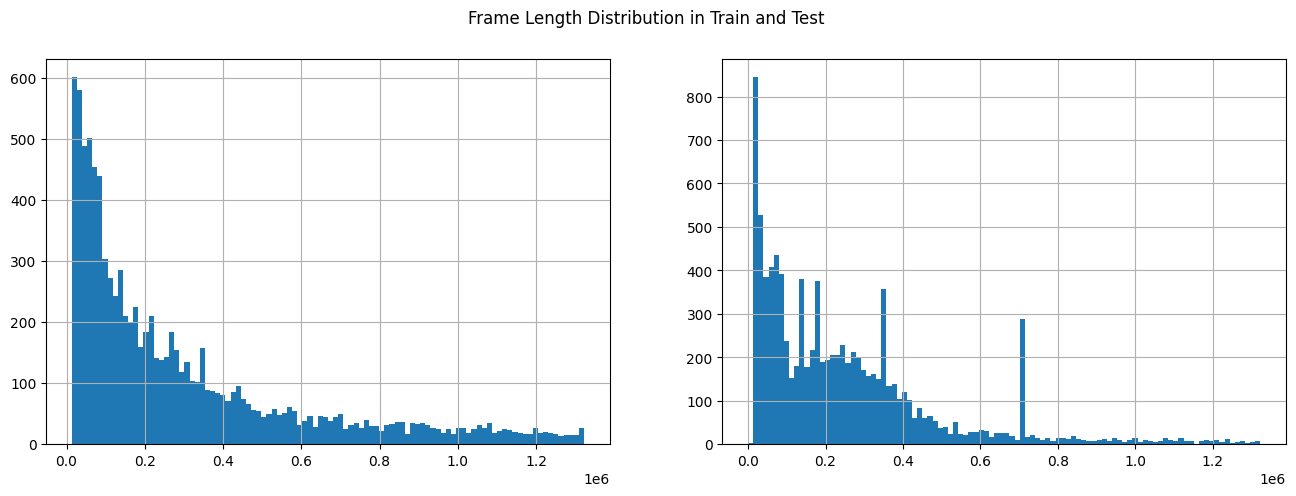

In [43]:
#распределение длины кадра в Train и Test.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
train.nframes.hist(bins=100, ax=axes[0])
test.nframes.hist(bins=100, ax=axes[1])
plt.suptitle('Frame Length Distribution in Train and Test', ha='center', fontsize='large');
#Большинство аудиофайлов короткие. На гистограмме теста есть четыре аномальных значения длины.  в тесте есть 4 скачка странных

In [56]:
abnormal_length = [707364, 353682, 138474, 184338]

for length in abnormal_length:
    abnormal_fnames = test.loc[test.nframes == length, 'fname'].values
    print("Frame length = ", length, " Number of files = ", abnormal_fnames.shape[0], end="   ")
    fname = np.random.choice(abnormal_fnames)
    print("Playing ", fname)
    IPython.display.display(ipd.Audio( '../input/freesound-audio-tagging/audio_test/' + fname))

Frame length =  707364  Number of files =  210   Playing  ab6a14cf.wav


Frame length =  353682  Number of files =  127   Playing  261331aa.wav


Frame length =  138474  Number of files =  170   Playing  d441f366.wav


Frame length =  184338  Number of files =  153   Playing  f27a6fcd.wav


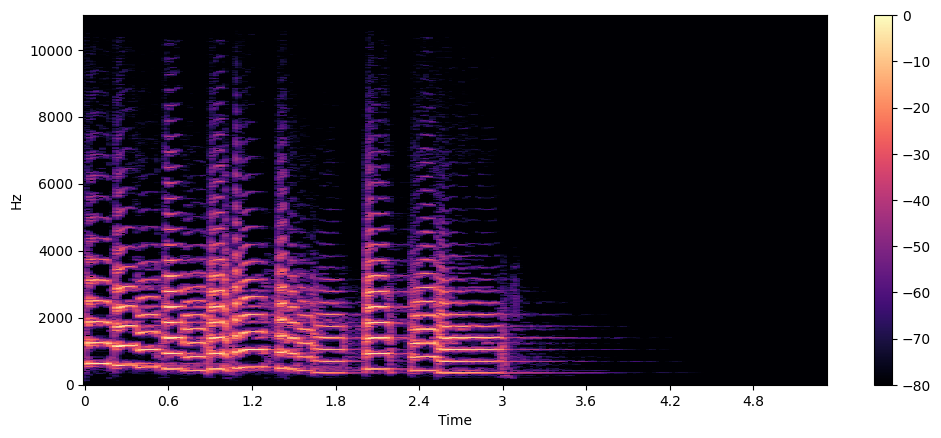

In [49]:
#спектограмма
import librosa

array, sampling_rate = librosa.load(librosa.ex("trumpet"))

D = librosa.stft(array)# представляет аудио сигнал в матрицу время частота
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max) #преобразование в децибелы в от макс знач амплитуды
#рисование спектограммы
plt.figure().set_figwidth(12)#
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")#
plt.colorbar()#

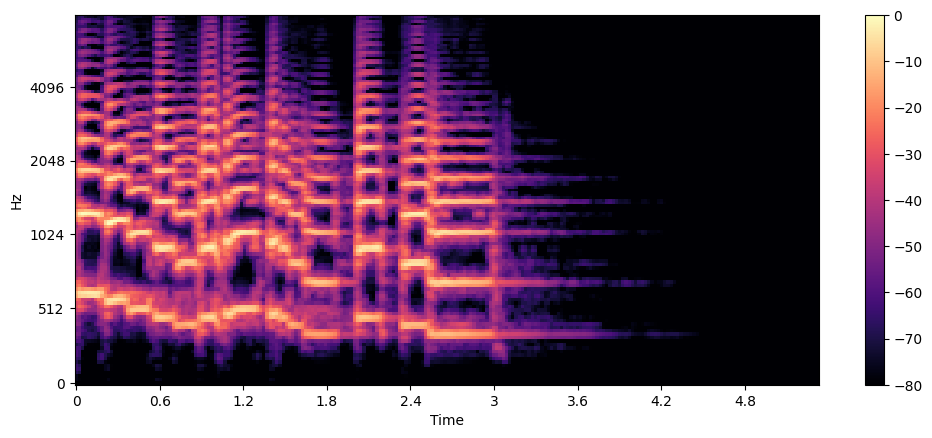

In [50]:
#Мел-спектрограмма представляет аудиосигнал в виде матрицы время-частота, 
#где столбцы представляют мел-частотные диапазоны, 
#а строки - время.
S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)# преобразование мозности в децибелы

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000)
plt.colorbar()